In [1]:
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from IPython.display import clear_output, display, HTML

import math
import numpy as np
import timeit

from scipy import integrate
from scipy.optimize import fsolve

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

from itertools import takewhile

from __future__ import division

## LRU cache hit ratio withChe's approximation ##
def solve_lru_che(M=1000, C=10, A=1.2):
    
    start_time = timeit.default_timer()
    
    # Zipf's distribution
    pdf = np.arange(1.0, M + 1.0) ** -A
    pdf /= np.sum(pdf)
    contents = range(len(pdf))
    
    #p = np.percentile(pdf,95)
    #print p

    #print("--- Catalog Cardinality M =", M, " ---")
    #print("--- Cache Size C =", C, " ---")
    #print("--- Zipf's Exponent \u03B1 =", A, " ---\n")

    # Che's Characteristic Time
    def tc_calc(T_C):
        return sum(math.exp(-pdf[j] * T_C) for j in range(len(pdf))) \
            - len(pdf) + C

    T_C = fsolve(tc_calc, x0=C)[0]
        
    print("Characteristic Time TC = %.2f" % T_C)

    # Che's Hit Ratio
    h_c = [1 - math.exp(-pdf[i] * T_C) for i in contents]
    h = sum(pdf[i] * h_c[i] for i in range(len(pdf)))

    elapsed = timeit.default_timer() - start_time
    
    print("Average Hit Ratio h(LRU) = %.2f" % (h*100), "%\n")
    print("Elapsed Time = %.4f" % elapsed, "s\n")
    
    #return h 

## LFU cache hit ratio ##
def solve_lfu(M=1000, C=10, A=1.2):
    
    start_time = timeit.default_timer()
    
    # Zipf's distribution
    pdf = np.arange(1.0, M + 1.0) ** -A
    pdf /= np.sum(pdf)
    contents = range(len(pdf))

    #print("--- Catalog Cardinality M =", M, " ---")
    #print("--- Cache Size C =", C, " ---")
    #print("--- Zipf's Exponent \u03B1 =", A, " ---\n")
    
    # Exact formula 
    h_lfu = sum(sorted(pdf, reverse=True)[:C]) 
    
    elapsed = timeit.default_timer() - start_time
    
    print("Average Hit Ratio h(LFU) = %.2f" % (h_lfu*100), "%\n")
    print("Elapsed Time = %.4f" % elapsed, "s\n")
    
    #return h_lfu
    
## LFU cache hit ratio - Approximate Solution ##
def solve_lfu_approx(M=1000, C=10, A=1.2):
    
    start_time = timeit.default_timer()
    
    if A == 1:
        h_lfu_app = np.log(C) / np.log(M)
    elif A < 1:   ## Not sure to put this...it really sucks for low C and M
        h_lfu_app = (C/M)**(1-A)
    else:
        h_lfu_app = solve_lfu(M, C, A)
        
    elapsed = timeit.default_timer() - start_time
        
    print("Average Hit Ratio h(LFU_APPROX) = %.2f" % (h_lfu_app*100), "%\n")
    print("Elapsed Time = %.4f" % elapsed, "s\n")

# PART 1 - Caching: What, Why, and How

The _hit ratio_ $h$, and so the resulting user experience connected to the performance of a caching system, is the result of multiple factors interplaying with each other, as shown in Fig. \MT{Add a figure with a sum of all factors giving the final hit ratio}. Well known classes of each factor are listed in the following.

## Content Popularity
The context a caching system is used in, and especially _how_ requests are issued for contents identified by a particular  _popularity distribution_, represents one of the influencing factors for the final hit ratio $h$.

 * __Zipf's law__ 
    
    It is considered as the de facto popularity distribution (along with Weibull and Mandelbrot-Zipf ones) that best approximates the dynamics of common Internet services, from popularity of requested contents in a P2P network or in a CDN, to distribution of requests for websites, or popularity of videos in a streaming platform.   
    In particular, denoting with $M$ the _catalog cardinality_, and with $1 \le i \le M$ the rank of the $i$-th most popular content, the probability of requesting the content with rank $i$ is expressed as:
    \begin{equation}
    P(X=i)=\frac{i^{-\alpha}}{B}.
    \label{eq:zpf}
    \end{equation}    
    where $B=1/\sum_{j=1}^M{j^{-\alpha}}$, and $\alpha > 0$.   
    Clearly, the value of the Zipf exponent $\alpha$ plays a paramount role in determining the caching performance; indeed, the percentage of requests directed to the $C$ most popular contents, i.e., $P(C)=\sum_{i=1}^C{P(X=i)}$, heavily varies with $\alpha$.  
    For large values of $\alpha$, e.g., $\alpha=2$, and supposing a catalog with a cardinality of $M=10^8$ contents, $C=12$ represents the content correspondent to the 95-th percentile of requests, meaning that 95\% of requests are directed towards only the $C=12$ most popular contents (as $\sum_{i=1}^{12}{P(X=i)} > 0.95 \ \ for \ \ \alpha=2$). At the same time, with $\alpha=0.8$, for example, the head of the catalog for which the 95\% of requests is directed becomes much wider, being $C=$ <span style="color:blue">\MT{complete}</span>.  
    It can be concluded that the higher $\alpha$, the smaller the size of the cache needed to guarantee a certain hit ratio $h$.   
    
    It is worth noticing, also, that the whole Internet traffic is made of a mixture of different "types" of traffic (Web, P2P, Video, etc.), each one with a specific set of parameters, content popularity (expressed in terms of request frequency) being one of them. This is the reason why there is neither a single $\alpha$ value that characterizes all the scenarios above, nor a broad consensus on the particular $\alpha$ that needs to be use to model each type of traffic. Empirical studies have tried to provide intervals for each application: for example, for Web and File Sharing traffic $\alpha \in [0.6,0.85]$, for VoD $\alpha \in [0.65,1]$, and for UGC $\alpha \ge 2$ <span style="color:blue">[DraftPentikousis:16]</span>.
    
## Temporal Locality
The temporal dynamics of popularity, i.e., how requests are distributed in time, complement the information provided by popularity distribution, which expresses only the number of requests submitted for each content, without describing how these requests are distributed in time. This aspect is of primary importance when considering the performance of caching schemes since the ordering of the requests obviously affects the contents that will be stored inside the cache. 
There exists several models used to characterize the pattern of requests arriving at a cache:

* __Independent Reference Model (IRM)__

This model, widely adopted in the literature due to its simplicity, is based on the following fundamental assumptions: i) users request items from a fixed catalog of $M$ objects; ii) the probability $P(X=m)$ that a request is for object $m$, $1 \le m \le M$, is constant (i.e., the object popularity does not vary over time) and independent of all past requests, generating an i.i.d. sequence of requests.
It results that the IRM completely ignores all temporal correlations in the sequence of requests (aka temporal locality), i.e., the fact that, if an object is requested at a given point in time, then it is more likely that the same object will be requested again in the near future (a characteristic that increase the hit ratio $h$ of a cache).

* __Shot Noise Model (SNM)__ <span style="color:blue">[garetto15infocom]</span>

The basic idea is to represent the overall request process as the superposition of many independent processes (shots), each referring to an individual content. Specifically, the arrival process of requests for a given content $m$ at a cache is described by an inhomogeneous Poisson process of intensity $V_m h(t - t_m)$, where $V_m$ denotes the average number of requests attracted by the content, $t_m$ is the time instant at which the content enters the system (i.e., it becomes available to the users), and $h()$ is the (normalized) "popularity profile" of content $m$. The SNM models, in this way, the evolution of content popularity over time.

## Spatial Locality
It refers to the way requests are geographically distributed throughout the network. 
Being able to characterize request patterns in different areas of the network might help avoiding redundant traffic in the network itself; indeed, if requests are highly localized in some areas of the entire network, then similar requests can be more efficiently served with mechanisms such as caching.

## Replacement Policy
Since caches have a limited amount of space to store contents (which we suppose being equal to $C$ contents), we need a _replacement policy_ to decide which content needs to be evicted when the cache is full and a new content needs to be stored. 
Among several techniques, the most adopted and studied ones are:  
* __LFU__: in its classic implementation, a _Least Frequently Used_ cache keeps track of the access frequency by assigning a counter to each stored content, and evicting the one with the lowest counter when the cache is full. Furthermore, if the content popularity is known a priori, a LFU cache can be implemented by statically storing the $C$ most popular contents, thus providing optimal performance under IRM. However, a pure LFU system is discouraged in real contexts with evolving popularity (e.g., newly cached items with low counters might be soon evicted even though they might be required frequently thereafter). 
* __LRU__: a _Least Recently Used_ cache will evict the content that has not been requested for the longest time, in case a new content needs to be inserted in the cache, and there are already $C$ contents stored in it. This means that each time a cached content is requested, its timer is updated. A LRU cache provides the best compromise between performance and easy implementation.   
* __FIFO__: in this case, the timer of cached contents is not updated in case of a cache hit; as a consequence, the content that has been inserted since the longest time is evicted if the cache is full.
* __RANDOM__: the content to be evicted in case of a full cache is selected randomly.


## Admission Policy
The effective storage of a newly arrived content inside the cache can be regulated by an _admission policy_, which might be related or not to the "position" of the cache itself inside the whole network topology.  
The most diffused techniques are:  
* __LCE__: with _Leave Copy Everywhere_, a newly arrived content is aways cached, if not already stored inside the cache.
* __LCP__: _Leave Copy Probabilistically_ adds a filter to LCE, in the sense that a newly arrived content will be cached only with probability $p$, a parameter that can be set in order to change the caching behavior and reduce the so called _cache pollution_ (i.e., the worthless caching of unpopular contents). 
* __2-LRU__: a more affective way than LCP to reduce cache pollution is provided by this strategy <span style="color:blue">[martina14infocom]</span>; before the physical cache, where actual objects are stored, there is a second cache where only content IDs of incoming requests are stored following a LRU policy. Therefore, only contents whose ID is found in the first cache are then cached in the physical one when fetched from upstream nodes. This provides a self-tuning filter that reduces cache pollution and which can cope with the temporal evolution of content popularity.     
* __LCD__: in a hierarchical network of caches, the _Leave Copy Down_ strategy leaves a copy of the requested content only inside the cache which is one hop below the cache the content has been found in. 


# PART 2 - Cost and errors of computing Cache Hit Ratio $h$ 
With notions of PART 1, we are now ready to go one step further and have a quick overview of the available analytical tools used to compute the _cache hit ratio_ $h$. 
In particular, we are interested in their computational complexity and in assessing potential errors that can be introduced when relying on simplifications. 
Due to the numerous and diverse scenarios that might result from the combination of the different factors seen above, in this TP we will make the following assumptions:  
(i) we consider a system composed by a _single cache_ under  
(ii) an IRM request model, and  
(iii) we focus on the specific aspect of _replacement policies_, considering LFU and LRU as case studies.  

## LFU
As seen in PART 1, the quantile of the Zipf distribution for an object of rank $C$ of a catalog with cardinality $M$ can be written as:

\begin{equation}\label{quantile}
P(C)=\frac{\sum_{k=1}^C{1/k^\alpha}}{\sum_{k=1}^M{1/k^\alpha}},  
\end{equation}

which also represents the aggregate rate for the $C$ most popular contents.
Considering that a single LFU cache with size $C$ statically stores the $C$ most popular contents, it results that Eq. (\ref{quantile}) also corresponds to the _cache hit ratio_ $h$ of that cache:

\begin{equation}\label{hit_lfu}
h_{LFU} = P(C)
\end{equation}

As soon as $M$ and $C$ becomes comparable to real values found in a CDN (e.g., $M>10^6$), the computational complexity of Eq. (\ref{hit_lfu}) starts to increase remarkably.
You can have a direct experience by executing the following configurable example!


In [3]:
#%%time
h3 = interact_manual(solve_lfu, M=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9], \
                     C=[10, 100, 1000, 10000, 100000, 1000000], \
                     A=[0.8, 1.0, 1.2])
#display(h3)

However, depending on the value of the Zipf exponent $\alpha$, it is possible to find a closed form expression for $h_{LFU}$ which approximates the exact result seen before.

* __$\alpha = 1$__
  
  In this case, numerator and denominator of Eq. (\ref{quantile}) correspond to the Harmonic numbers $H_C = \sum_{k=1}^C  1/k$ (and $H_M$), which are known to be well approximated asymptotically by a logarithmic function, since
  
  \begin{align}
  \lim_{X\rightarrow \infty} H_X  - ln(X) = \gamma ,
  \end{align}
  
  where $\gamma\approx 0.57$ is the Euler-Mascheroni constant. Hence, in the large $C$ and $M$ regime, we have:
  
  \begin{align}\label{lfu_app}
  h^{app}_{LFU}\approx ln(C)/ln(M). 
  \end{align}

  The plot below compares the true hit ratio $h$ computed with the exact formula of Eq. (\ref{hit_lfu}) for a fixed size cache $C$ and varying $M$ against its approximation shown in Eq. (\ref{lfu_app}). It can be noticed that despite (i) this approximation works as better as $C$ and $M$ increase, (ii) a non-negligible error persists in every case. There is, indeed, a compromise to accept between computational ease and prediction error. 

    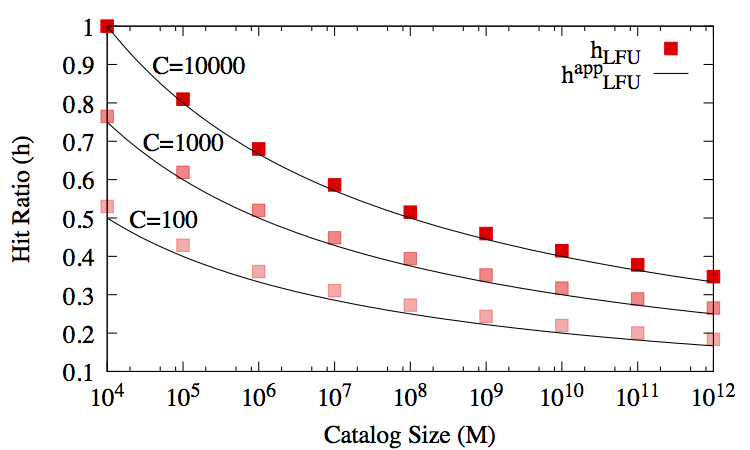


* __$\alpha < 1$__

  In this particular case, the harmonic number can be approximated as:
  
  \begin{equation}
  H_C \approx \int_{1}^{C} 1/x^{\alpha} dx = \frac{x^{(1-\alpha)}}{1-\alpha} = \frac{C^{(1-\alpha)}}{1-\alpha}
  \end{equation}
  
  It follows that:
  
  \begin{equation}\label{eq:lfu_app_ah1}
  h^{app}_{LFU} \approx \frac{C^{(1-\alpha)}}{M^{1-\alpha}} = \left(\frac{C}{M}\right)^{1-\alpha}
  \end{equation}

  It is worth noticing that the approximation shown in Eq. (\ref{eq:lfu_app_ah1}) comes with a higher absolute error (i.e., $|h_{LFU}-h^{app}_{LFU}|$) with respect to the approximation of Eq. (\ref{lfu_app}) <span style="color:blue">[Insert an explicative plot]</span>
  

    \begin{figure}[t] 
    \centering
    \includegraphics[width=0.7\textwidth]{QuellaSporcaDozzina.pdf}
    \caption{Single LFU cache with fixed size $C$ and varying cardinality $M$. True hit ratio $h_{LFU}$ vs its approximation $h^{app}_{LFU}$ for $\alpha=1$.}
    \label{fig:lfu_approx_a1}
    \end{figure} 
    
* __$\alpha > 1$__

    There exists no approximation for this case.
    
You can compare accuracy and execution time w.r.t. the exact solution through the following solver: 
    

In [4]:
#%%time
h3 = interact_manual(solve_lfu_approx, M=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9], \
                     C=[10, 100, 1000, 10000, 100000, 1000000], \
                     A=[0.8, 1.0])
#display(h3)

## LRU
The computational complexity of exactly predicting the cache hit ratio $h$ for a single cache with LRU replacement policy lies in the exponential growth with cache size $C$ or with catalog cardinality $M$ <span style="color:blue">[King:71]</span>, which makes impossible to obtain the final results in a reasonable amount of time for real scenarios (i.e., with $M \ge 10^8$).
Therefore, the only feasible way to obtain a reference point is by simulation. 
However, plenty of models and approximations have been proposed so far, among which Che's approximation <span style="color:blue">[wang02jsac_hierarchical]</span> represents the most adopted and effective one. It was initially conceived for a single cache with LRU replacement policy and IRM traffic, and then successively extended for other traffic types, replacement and admission policies <span style="color:blue">[martina14infocom]</span>.

### Che's Approximation <span style="color:blue">[wang02jsac_hierarchical]</span>

The core intuition is that of considering the eviction time $T_C(m)$ for content $m$, with $1 \le m \le M$, as if it was a constant value $T_C$, known as "characteristic time", independent of the content $m$. In particular, $T_C(m)$ can be considered for a cache of size $C$ as the time needed before $C$ distinct contents (excluding $m$) are requested, i.e., the time since the last request (for $m$) after which content $m$ will be evicted (provided that it has not been requested in the meanwhile).  
Che's assumption greatly simplifies the analysis of caching systems because it allows to decouple the dynamics of different contents: the interaction among contents is summarized by $T_C$, which acts as a single primitive quantity representing the response of the whole cache to an object request.  
Formally speaking, Che's approximation states that an object $m$ is in the cache at time $t$, if and only if a time smaller than $T_C$ has elapsed since the last request for object $m$, i.e., if at least a request for $m$ has arrived in the interval $(t - T_C, t]$. Under the assumption that requests for object $m$ arrive according to a Poisson process of rate $\lambda_m$, the time-average probability $p_{in}(m)$ that object $m$ is in the cache is given by:

\begin{equation}\label{eq:pin}
p_{in}(m) = 1 - e^{-\lambda_m T_C}
\end{equation}

It is worth noticing that $p_{in}(m)$ represents also the hit probability $p_{hit}(m)$ (thanks to PASTA's property), i.e., the probability that a request for content $m$ finds content $m$ inside the cache.  
Denoting  with $\mathbb{1}_{\text{\{A\}}}$ the indicator function for event $A$, we have that by construction, cache size $C$ must satisfy:

\begin{equation}\label{eq:TC}
C=\mathbb{E}\left[ \sum_m \mathbb{1}_{\{\text{$m$ in cache at t}\}}\right]= \sum\limits_{m} p_{in}(\lambda_m,T_C).
\end{equation} 

It follows that the characteristic time $T_C$ can be computed by numerically inverting Eq. \ref{eq:TC}, which admits a single solution<span style="color:blue">[wang02jsac_hierarchical]</span>.

The _average hit probability_ $h$ of a LRU cache is then:

\begin{equation}
h = \sum_m p_m p_{hit(m)}
\end{equation}

You can directly test the efficiency of Che's approximation by using the following solver:

In [25]:
#%%time
h2 = interact_manual(solve_lru_che, M=[1e4, 1e5, 1e6, 1e7, 1e8, 1e9], \
                     C=[10, 100, 1000, 10000, 100000, 1000000], \
                     A=[0.8, 1.0, 1.2])
#display(h2)